In [2]:
import pandas as pd
import tensorflow as tf
import yfinance as yf
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input,GlobalAveragePooling1D
from keras import optimizers
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime, timedelta
import math

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5417704254982791441
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17710582150715938097
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [4]:
timestep = 100
testfrac = 0.25
valfrac = 0.2

In [5]:
start_date = '2010-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dataclose = np.array([data['Close']]).transpose()
display(dataclose.shape)

'2024-01-24'

[*********************100%%**********************]  1 of 1 completed


(2267, 1)

In [6]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
dataclose = pd.DataFrame(dataclose)
diffclose = (dataclose - dataclose.shift(1))*100/dataclose.shift(1)
data.insert(5, 'Diffclose', diffclose)
conditions = [
    (data['Diffclose'] < -25),
    (data['Diffclose'] >= -25) & (data['Diffclose'] < -15),
    (data['Diffclose'] >= -15) & (data['Diffclose'] < -5),
    (data['Diffclose'] >= -5) & (data['Diffclose'] <= 5),
    (data['Diffclose'] > 5) & (data['Diffclose'] <= 15),
    (data['Diffclose'] > 15) & (data['Diffclose'] <= 25),
    (data['Diffclose'] > 25)
    ]
values = ['Extreme Bear', 'Strong Bear', 'Weak Bear', 'Neutral', 'Weak Bull', 'Strong Bull', 'Extreme Bull']
data['Direction'] = np.select(conditions, values)
display(data)

,Open,High,Low,Close,Volume,Diffclose,Direction
0,308.644989,329.451996,307.056000,320.884003,893249984,NaN,0
1,320.670990,324.717987,294.541992,299.252991,885985984,-6.741069,Weak Bear
2,298.585999,319.453003,298.191986,314.681000,842300992,5.155507,Weak Bull
3,314.690002,319.153015,298.513000,307.907990,1613479936,-2.152342,Neutral
4,307.024994,328.415009,307.024994,316.716003,1041889984,2.860599,Neutral
...,...,...,...,...,...,...,...
2262,2468.688965,2501.305176,2414.710938,2489.498535,11405278376,0.911211,Neutral
2263,2489.847656,2489.847656,2456.095703,2469.589111,5297826161,-0.799736,Neutral
2264,2469.798584,2479.760498,2452.377686,2453.913086,4578471955,-0.634762,Neutral
2265,2454.987305,2463.447266,2303.502686,2310.826416,13923771728,-5.830959,Weak Bear


In [7]:
data.drop(['Diffclose'], axis=1, inplace=True)
display(data)

,Open,High,Low,Close,Volume,Direction
0,308.644989,329.451996,307.056000,320.884003,893249984,0
1,320.670990,324.717987,294.541992,299.252991,885985984,Weak Bear
2,298.585999,319.453003,298.191986,314.681000,842300992,Weak Bull
3,314.690002,319.153015,298.513000,307.907990,1613479936,Neutral
4,307.024994,328.415009,307.024994,316.716003,1041889984,Neutral
...,...,...,...,...,...,...
2262,2468.688965,2501.305176,2414.710938,2489.498535,11405278376,Neutral
2263,2489.847656,2489.847656,2456.095703,2469.589111,5297826161,Neutral
2264,2469.798584,2479.760498,2452.377686,2453.913086,4578471955,Neutral
2265,2454.987305,2463.447266,2303.502686,2310.826416,13923771728,Weak Bear


In [11]:
data.to_csv('data.csv')
result = np.array([data['Direction']]).transpose()

In [26]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data[['Open', 'High', 'Low', 'Close', 'Volume']]))
Yscaler = OneHotEncoder()
Ydata = result
Yscaler.fit(Ydata)
display(Xdata.shape)
display(Ydata.shape)

(2267, 5)

(2267, 1)

In [27]:
X_temp, X_test = train_test_split(Xdata, test_size=testfrac, shuffle=False)
Y_temp, Y_test = train_test_split(Ydata, test_size=testfrac, shuffle=False)
X_train, X_val = train_test_split(X_temp, test_size=valfrac, shuffle=False)
Y_train, Y_val = train_test_split(Y_temp, test_size=valfrac, shuffle=False)

In [32]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((dim_0, Ydata.shape[1]))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [33]:
X_train, Y_train = build_timeseries(X_train, Y_train, timestep)
X_test, Y_test = build_timeseries(X_test, Y_test, timestep)
X_val, Y_val = build_timeseries(X_val, Y_val, timestep)
print("X Train Shape: ", X_train.shape, "   Y Train Shape: ", Y_train.shape)
print("X Val Shape: ", X_val.shape, "   Y Val Shape: ", Y_val.shape)
print("X Test Shape: ", X_test.shape, "   Y Test Shape: ", Y_test.shape)

ValueError: could not convert string to float: 'Neutral'

In [30]:
def model_builder(hp):
    lstm_model = Sequential()
    
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(LSTM(units=256, return_sequences=True))
    lstm_model.add(LSTM(units=128, return_sequences=True))
    lstm_model.add(LSTM(units=128, return_sequences=True))
    lstm_model.add(GlobalAveragePooling1D())
    lstm_model.add(Dense(units=64,activation='relu'))
    lstm_model.add(Dense(units=64,activation='relu'))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Dense(units=32, activation='linear'))
    lstm_model.add(Dense(units=8))
    lstm_model.summary()
    
    hyperparameters_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.05, 0.1])
    
    lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hyperparameters_learning_rate))
    
    return lstm_model

In [13]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=100)
tuner.search(X_train, Y_train, epochs=25, validation_data=(X_val,Y_val))
lstm_model  = tuner.get_best_models()[0]  
print(lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Reloading Tuner from .\untitled_project\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 192)          152064    
                                                                 
 lstm_1 (LSTM)               (None, 100, 144)          194112    
                                                                 
 lstm_2 (LSTM)               (None, 100, 144)          166464    
                                                                 
 lstm_3 (LSTM)               (None, 100, 144)          166464    
                                                                 
 lstm_4 (LSTM)               (None, 100, 144)          166464    
                                                                 
 global_average_pooling1d (G  (None, 144)              0         
 lobalAveragePooling1D)                                          
    

In [14]:
lstm_model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 100,batch_size = 128,verbose = 1)

Epoch 1/100
10/10 [==============================] - 13s 177ms/step - loss: 0.0069 - val_loss: 0.0566
Epoch 2/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0062 - val_loss: 0.0420
Epoch 3/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0059 - val_loss: 0.0560
Epoch 4/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0058 - val_loss: 0.0433
Epoch 5/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0055 - val_loss: 0.0439
Epoch 6/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0056 - val_loss: 0.0424
Epoch 7/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0054 - val_loss: 0.0408
Epoch 8/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0054 - val_loss: 0.0664
Epoch 9/100
10/10 [==============================] - 0s 45ms/step - loss: 0.0055 - val_loss: 0.0636
Epoch 10/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0056 - val_loss: 0.06

In [15]:
train_predict = lstm_model.predict(X_train)
val_predict = lstm_model.predict(X_val)
test_predict = lstm_model.predict(X_test)
train_predictraw = Yscaler.inverse_transform(train_predict).reshape((train_predict.shape[0],))
val_predictraw = Yscaler.inverse_transform(val_predict).reshape((val_predict.shape[0],))
test_predictraw = Yscaler.inverse_transform(test_predict).reshape((test_predict.shape[0],))

15/15 [==============================] - 0s 17ms/step


In [16]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_val,val_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

0.04566211497776743
0.43821685248870723
0.22781029632395197


In [17]:
dataclose = dataclose.transpose()[0]
display(dataclose)

array([ 320.88400269,  299.25299072,  314.68099976, ..., 2489.49853516,
       2469.58911133, 2453.91308594])

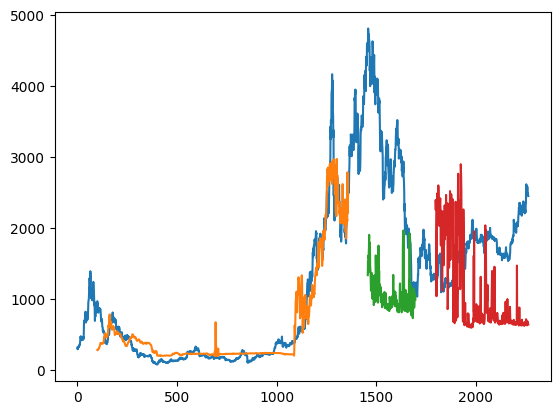

In [18]:
plt.plot(dataclose)

trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot.fill(np.nan)
trainPredictPlot[timestep:len(train_predictraw)+timestep:] = train_predictraw
plt.plot(trainPredictPlot)

valPredictPlot = np.empty_like(dataclose)
valPredictPlot.fill(np.nan)
valPredictPlot[len(train_predictraw)+timestep*2:len(train_predictraw)+timestep*2+len(val_predictraw):] = val_predictraw
plt.plot(valPredictPlot)

testPredictPlot = np.empty_like(dataclose)
testPredictPlot.fill(np.nan)
testPredictPlot[len(train_predictraw)+timestep*3+len(val_predictraw):len(train_predictraw)+timestep*3+len(val_predictraw)+len(test_predictraw):] = test_predictraw
plt.plot(testPredictPlot)

plt.show()